In [2]:
# !git clone https://github.com/dmc27/missing_pixels.git

In [1]:
import cv2 as cv
import numpy as np
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from sklearn.metrics import accuracy_score

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import load_model
# from tensorflow.keras.callbacks import ModelCheckpoint
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR


from utils.utils import *
from utils.database import MissingPixelDataset
from model.architecture import *


import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.dpi"] = 120

from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 16px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)



BLOCK_SIZE = 8
BATCH_SIZE = 1024
NUM_EPOCHS = 30
LEARNING_RATE = 1e-3
# WEIGHT_DECAY = 0.05
STEPLR_GAMMA = 0.1
RUN_UTILITY = False

IMG_TEST_PATH = './dataset/original_image/'
IMG_TRAINING_PATH = './dataset/training_image/train/'
IMG_SAVE_PATH = './dataset/missing_pixel/'

In [2]:
if RUN_UTILITY:
    create_dataset_autoencoder(IMG_PATH, IMG_SAVE_PATH, BLOCK_SIZE, img_size=(256, 256))

In [3]:
# Calling PrepareDataset class in the utilities for preparing the dataset for training,
# X is the input to the network architecture, and y is the target output of the network
data = PrepareDataset(IMG_TRAINING_PATH, IMG_TEST_PATH, IMG_SAVE_PATH, block_size=BLOCK_SIZE)
X, y = data.create_dataset_2d(sample_size = 100)
X_test, y_test = data.create_test_2d()


# Creating dataset for the pytorch model (converted to tensor)
train_dataset = MissingPixelDataset(X, y, scaling=False)
test_dataset = MissingPixelDataset(X_test, y_test, scaling=False)


# Create training dataloader to make a batch learning for the pytorch model
train_dataloader = DataLoader(train_dataset, shuffle=True, num_workers=0, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, shuffle=False, num_workers=0, batch_size=BATCH_SIZE)

100%|██████████| 55/55 [00:00<00:00, 2109.56it/s]


In [4]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
model = ConvModel1().double().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=10, gamma=STEPLR_GAMMA)

In [6]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    
    train_loss = 0
    pbar = tqdm(train_loader)
    for batch_idx, (X_train, y_train) in enumerate(pbar):
        X_train, y_train = X_train.to(device), y_train.to(device)
        
        output = model(X_train.unsqueeze(1))
        
        loss = criterion(output, y_train)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
        pbar.set_description(desc= f'Epoch {epoch} loss={loss.item()} batch_id={batch_idx}')
    
    train_loss /= len(train_loader.dataset)

    print('Train set: Average loss: {:.32f}'.format(train_loss))

In [7]:
def test(model, device, test_loader, criterion):

    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to keep track of the loss and accuracy
    test_loss = 0

    # Use tqdm to display the progress of the testing loop
    pbar = tqdm(test_loader)
    with torch.no_grad():
        for batch_idx, (test_X, test_y) in enumerate(pbar):
            test_X, test_y = test_X.to(device), test_y.to(device)
            
            output = model(test_X.unsqueeze(1))
            
            loss = criterion(output, test_y)
            test_loss += loss.item()

    
    test_loss /= len(test_loader.dataset)

    # Print the results
    print('Test set: Average loss: {:.32f}'.format(test_loss))
    print()
    return test1

In [8]:
# model.load_state_dict(torch.load('./trained_model/convmodel_30k_0.pth'))

In [9]:
for epoch in range(1, NUM_EPOCHS + 1):
    train(model, device, train_dataloader, optimizer, criterion, epoch)
    test(model, device, test_dataloader, criterion)
    # plot_loss()
    # test(model, device, test_dataloader, criterion)
    # scheduler.step()

Epoch 1 loss=0.0045487416164813315 batch_id=99: 100%|██████████| 100/100 [00:05<00:00, 19.57it/s]


Train set: Average loss: 0.00001007478374760413957530579693


100%|██████████| 55/55 [00:00<00:00, 83.20it/s]


Test set: Average loss: 0.00000393448882035231136663827253



Epoch 2 loss=0.0032520020183552743 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 36.55it/s]


Train set: Average loss: 0.00000369336996464272983712912209


100%|██████████| 55/55 [00:00<00:00, 78.77it/s]


Test set: Average loss: 0.00000388678539693596691992003023



Epoch 3 loss=0.0036394854477976293 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.34it/s]


Train set: Average loss: 0.00000344269388389729294661892496


100%|██████████| 55/55 [00:00<00:00, 83.36it/s]


Test set: Average loss: 0.00000346069035596165854623182910



Epoch 4 loss=0.0032604747132348308 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.49it/s]


Train set: Average loss: 0.00000334480425115627546338152067


100%|██████████| 55/55 [00:00<00:00, 83.05it/s]


Test set: Average loss: 0.00000339062682473026234952089876



Epoch 5 loss=0.003255612517234353 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 36.57it/s]


Train set: Average loss: 0.00000331084256350812029402849897


100%|██████████| 55/55 [00:00<00:00, 80.33it/s]


Test set: Average loss: 0.00000331214950954467388411785710



Epoch 6 loss=0.002895435652076648 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.50it/s]


Train set: Average loss: 0.00000312695503345434479172508524


100%|██████████| 55/55 [00:00<00:00, 81.59it/s]


Test set: Average loss: 0.00000333396906922540107854713125



Epoch 7 loss=0.00313827281579929 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.70it/s] 


Train set: Average loss: 0.00000313594963374690080027979572


100%|██████████| 55/55 [00:00<00:00, 83.01it/s]


Test set: Average loss: 0.00000334209267834084442803997510



Epoch 8 loss=0.002761156621409999 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.32it/s]


Train set: Average loss: 0.00000310759419821227029863863929


100%|██████████| 55/55 [00:00<00:00, 78.98it/s]


Test set: Average loss: 0.00000303042592015024737402010060



Epoch 9 loss=0.0035965507853418055 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 36.37it/s]


Train set: Average loss: 0.00000306169039274194806216078391


100%|██████████| 55/55 [00:00<00:00, 83.85it/s]


Test set: Average loss: 0.00000314126301030209574872433496



Epoch 10 loss=0.002559029359771228 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.61it/s]


Train set: Average loss: 0.00000289982418927364430104353168


100%|██████████| 55/55 [00:00<00:00, 81.56it/s]


Test set: Average loss: 0.00000304100207767632150035008558



Epoch 11 loss=0.0032069601636047947 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.48it/s]


Train set: Average loss: 0.00000297725128661662724138901176


100%|██████████| 55/55 [00:00<00:00, 78.92it/s]


Test set: Average loss: 0.00000303759553937919542815240641



Epoch 12 loss=0.0029222528602935965 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 36.35it/s]


Train set: Average loss: 0.00000287338931310292675772358716


100%|██████████| 55/55 [00:00<00:00, 84.19it/s]


Test set: Average loss: 0.00000285734740645943528956842046



Epoch 13 loss=0.0028525584001527493 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.59it/s]


Train set: Average loss: 0.00000280210079152473758777553911


100%|██████████| 55/55 [00:00<00:00, 80.27it/s]


Test set: Average loss: 0.00000294703696708248773458737636



Epoch 14 loss=0.003125269969013922 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.64it/s]


Train set: Average loss: 0.00000271914895688737973816501842


100%|██████████| 55/55 [00:00<00:00, 77.63it/s]


Test set: Average loss: 0.00000276630099542730906154270817



Epoch 15 loss=0.002709032175995587 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.78it/s]


Train set: Average loss: 0.00000275818702935582411484732347


100%|██████████| 55/55 [00:00<00:00, 82.77it/s]


Test set: Average loss: 0.00000284135657676326143562827754



Epoch 16 loss=0.0030114806373667193 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 36.44it/s]


Train set: Average loss: 0.00000264495422180496499224523418


100%|██████████| 55/55 [00:00<00:00, 78.02it/s]


Test set: Average loss: 0.00000269907983978653059903415543



Epoch 17 loss=0.0027107471323985525 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.23it/s]


Train set: Average loss: 0.00000279087438539044447010761124


100%|██████████| 55/55 [00:00<00:00, 79.95it/s]


Test set: Average loss: 0.00000273228614234958489480863120



Epoch 18 loss=0.0026924360709214756 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.70it/s]


Train set: Average loss: 0.00000258981260010253178566229718


100%|██████████| 55/55 [00:00<00:00, 83.54it/s]


Test set: Average loss: 0.00000276724370208294133817146856



Epoch 19 loss=0.0026958904017590954 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 36.49it/s]


Train set: Average loss: 0.00000257584640931099245823561808


100%|██████████| 55/55 [00:00<00:00, 79.09it/s]


Test set: Average loss: 0.00000269763837317839274391215003



Epoch 20 loss=0.002685818937214943 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.28it/s]


Train set: Average loss: 0.00000258910871484028714533819245


100%|██████████| 55/55 [00:00<00:00, 81.12it/s]


Test set: Average loss: 0.00000281488543164229250881543110



Epoch 21 loss=0.0024490662875347557 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.42it/s]


Train set: Average loss: 0.00000249988956461131366410693445


100%|██████████| 55/55 [00:00<00:00, 83.16it/s]


Test set: Average loss: 0.00000264770571417633897190425582



Epoch 22 loss=0.0023704762743744032 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.49it/s]


Train set: Average loss: 0.00000253443752875993340444482800


100%|██████████| 55/55 [00:00<00:00, 79.39it/s]


Test set: Average loss: 0.00000279875450689358432109291042



Epoch 23 loss=0.00217380594951653 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 36.44it/s] 


Train set: Average loss: 0.00000249758168217028185409812717


100%|██████████| 55/55 [00:00<00:00, 77.65it/s]


Test set: Average loss: 0.00000259956383591913054586933565



Epoch 24 loss=0.0025528139081313073 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.62it/s]


Train set: Average loss: 0.00000245827800399975698029432503


100%|██████████| 55/55 [00:00<00:00, 80.68it/s]


Test set: Average loss: 0.00000343717818209987550163975710



Epoch 25 loss=0.0025929179078095707 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.41it/s]


Train set: Average loss: 0.00000237037038388604350190006116


100%|██████████| 55/55 [00:00<00:00, 79.12it/s]


Test set: Average loss: 0.00000271293310742589391181640510



Epoch 26 loss=0.002318745115119503 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.33it/s]


Train set: Average loss: 0.00000240377205979769554305860817


100%|██████████| 55/55 [00:00<00:00, 92.43it/s]


Test set: Average loss: 0.00000268494576957770550313113651



Epoch 27 loss=0.002586360567347442 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.51it/s]


Train set: Average loss: 0.00000253081361344550133843475832


100%|██████████| 55/55 [00:00<00:00, 83.46it/s]


Test set: Average loss: 0.00000275027018905852565589052056



Epoch 28 loss=0.0025943663241757894 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.47it/s]


Train set: Average loss: 0.00000242733325278705322952709292


100%|██████████| 55/55 [00:00<00:00, 78.69it/s]


Test set: Average loss: 0.00000258203099938083481843876035



Epoch 29 loss=0.0019948941671275814 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 35.35it/s]


Train set: Average loss: 0.00000238202677844511090472149999


100%|██████████| 55/55 [00:00<00:00, 82.71it/s]


Test set: Average loss: 0.00000311618541939125008914061171



Epoch 30 loss=0.0026445422952073457 batch_id=99: 100%|██████████| 100/100 [00:02<00:00, 36.44it/s]


Train set: Average loss: 0.00000238043666860172218303578519


100%|██████████| 55/55 [00:00<00:00, 82.68it/s]

Test set: Average loss: 0.00000272579402125755479980814301



In [10]:
torch.save(model.state_dict(), 'trained_model/convmodel1_bn_trainsize_100_batchsize_1024.pth')

In [13]:
test_image_name = next(os.walk(IMG_TEST_PATH), (None, None, []))[2]

In [14]:
def test_model(test_img_path):
    model.eval()
    mse = []
    for test_path in test_img_path:
        image = data._preprocess_image('./dataset/original_image/' + test_path)
        tiled_image = data._reshape_split(image)
        X_test = tiled_image.copy()
        X_test[:, 3:5, 3:5] = np.array([[0., 0.],
                                    [0., 0.]])
        test = X_test / 255.
        prediction_result = model(torch.tensor(test, dtype=torch.float64).to(device).unsqueeze(1)).detach().cpu().numpy()
        prediction_result = prediction_result.reshape(-1, 2, 2) * 255.
        X_test[:, 3:5, 3:5] = prediction_result
        pred = X_test.reshape(32, 32, 8, 8).swapaxes(1, 2).reshape(256, 256)
        err = pred - image
        mse.append((err**2).mean())
    return mse

In [15]:
result = test_model(test_image_name)
print(np.mean(result))

11.343664398865444


In [8]:
model.eval()
image = data._preprocess_image('./dataset/original_image/balloon.bmp')
tiled_image = data._reshape_split(image)
X_test = tiled_image.copy()
X_test[:, 3:5, 3:5] = np.array([[None, None],
                            [None, None]])
test = X_test[~np.isnan(X_test)].reshape(-1, 60) / 255.
prediction_result = model(torch.tensor(test, dtype=torch.float64).to(device)).detach().cpu().numpy()
prediction_result = prediction_result.reshape(-1, 2, 2) * 255.
X_test[:, 3:5, 3:5] = prediction_result
pred = X_test.reshape(32, 32, 8, 8).swapaxes(1, 2).reshape(256, 256)
# a = model(torch.tensor(X[:1024], dtype=torch.float32).to(device)).detach().cpu().numpy()

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1024, 60]

In [16]:
model.eval()
image = data._preprocess_image('./dataset/original_image/' + 'balloon.bmp')
tiled_image = data._reshape_split(image)
X_test = tiled_image.copy()
X_test[:, 3:5, 3:5] = np.array([[0., 0.],
                            [0., 0.]])
test = X_test / 255.
prediction_result = model(torch.tensor(test, dtype=torch.float64).to(device).unsqueeze(1)).detach().cpu().numpy()
prediction_result = prediction_result.reshape(-1, 2, 2) * 255.
X_test[:, 3:5, 3:5] = prediction_result
pred = X_test.reshape(32, 32, 8, 8).swapaxes(1, 2).reshape(256, 256)

In [17]:
model.eval()
image = data._preprocess_image('./dataset/original_image/' + test_image_name)
missing_pixel_image = data._create_missing_pixel_img(image)
tiled_image = data._reshape_split(missing_pixel_image)
test = tiled_image / 255.
prediction_result = model(torch.tensor(test, dtype=torch.float64).to(device).unsqueeze(1)).detach().cpu().numpy()
# prediction_result.shape
pred = prediction_result.reshape(8, 8, 32, 32).swapaxes(1, 2).reshape(256, 256) * 255.

In [18]:
pred

array([[123.62653125, 124.76420595, 126.54586449, ..., 126.12510387,
        128.11056076, 129.43694876],
       [121.78977793, 122.74711119, 124.07674207, ..., 123.45325022,
        125.18749462, 125.98406633],
       [123.86609506, 124.33159764, 124.03614106, ..., 121.85183954,
        123.04041825, 122.87202033],
       ...,
       [123.11417536, 122.7502332 , 123.40343226, ..., 120.49163032,
        121.73810406, 121.0666087 ],
       [122.23041535, 122.41328859, 123.6936948 , ..., 121.46503923,
        122.92623304, 122.05038634],
       [121.56689347, 122.22990698, 123.50334852, ..., 123.55558173,
        124.32378024, 124.11034719]])

In [12]:
# # DO THE TRAINING
# # BATCH_SIZE = 4
# checkpoint = ModelCheckpoint(model_fname, monitor='loss', verbose=1,
#   save_best_only=True)
# callbacks_list = [checkpoint]

# # fit the model
# history = model.fit(X, y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
#   validation_split=0.1, callbacks=callbacks_list)
# # history = model.fit(X_trn, y_trn, epochs=200, batch_size=1,
# #   validation_split=0.1, callbacks=callbacks_list)

In [13]:
# pred = data.test_model(model=model)

MSE = 10.30


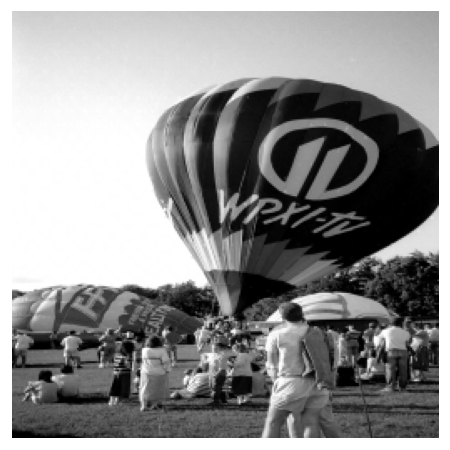

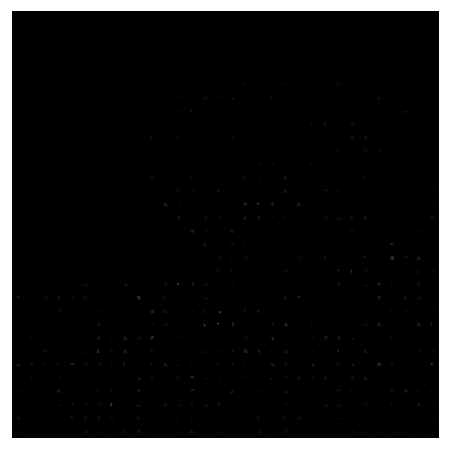

In [17]:
img = cv.imread(join(IMG_TEST_PATH, 'balloon.bmp'), cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (256, 256), cv.INTER_CUBIC)
img = img.astype(np.float64)

# compute the MSE between the original and reconstructed images
err = pred - img
print("MSE =", "{:.2f}".format((err**2).mean()))

imshow(pred, "gray", dpi=72)
imshow(pred - img, 'gray', dpi = 72)
